### Soil Moisture Level Data Download

This notebook gets surface soil moisture, total column soil moisture level, and precipitation data from the OCP data library located at [mary.ldeo.columbia.edu](http://mary.ldeo.columbia.edu:81/CMIP6/)

It then combines the variables into individual xarray dataarrays for each model, selects a defined region, and exports for ease of use elsewhere. 

I borrowed a lot of Kate's code from `CMIP6Helper.ipynb`

In [1]:
# data import
import zarr
import fsspec
import intake
from dask.diagnostics import ProgressBar

# data analysis
import numpy as np
import pandas as pd
import xarray as xr
import dask 
import xesmf as xe
xr.set_options(display_style='html')
import cftime

from functools import reduce

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

# plotting
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

import sys,os

Load a CSV describing data available in the OCP CMIP6 data library. 

Download the latest version with:

`wget http://mary.ldeo.columbia.edu/master_collection/mary_cmip6.csv`

In [2]:
global mary
mary = pd.read_csv("mary_cmip6.csv")

global downloaded_cmip6
downloaded_cmip6 = pd.read_csv("mary_cmip6.csv")

In [3]:
mary.head()

,activity_id,experiment_id,file_basename,file_dirname,file_fullpath,grid_label,institution_id,member_id,mip_era,source_id,table_id,time_range,variable_id,tracking_id,version
0,CFMIP,abrupt-2xCO2,clt_Amon_IPSL-CM6A-LR_abrupt-2xCO2_r1i1p1f1_gr...,/m2/haibo/CMIP6mon/CFMIP/IPSL/IPSL-CM6A-LR/abr...,/m2/haibo/CMIP6mon/CFMIP/IPSL/IPSL-CM6A-LR/abr...,gr,IPSL,r1i1p1f1,CMIP6,IPSL-CM6A-LR,Amon,185001-199912,clt,NaN,v20180605
1,CMIP,1pctCO2,pr_Amon_CNRM-CM6-1_1pctCO2_r1i1p1f2_gr_185001-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,gr,CNRM-CERFACS,r1i1p1f2,CMIP6,CNRM-CM6-1,Amon,185001-199912,pr,NaN,v20180626
2,CMIP,1pctCO2,rsuscs_Amon_CNRM-CM6-1_1pctCO2_r1i1p1f2_gr_185...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,gr,CNRM-CERFACS,r1i1p1f2,CMIP6,CNRM-CM6-1,Amon,185001-199912,rsuscs,NaN,v20180626
3,CMIP,1pctCO2,ua_Amon_CNRM-CM6-1_1pctCO2_r1i1p1f2_gr_185001-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,gr,CNRM-CERFACS,r1i1p1f2,CMIP6,CNRM-CM6-1,Amon,185001-199912,ua,NaN,v20180626
4,CMIP,1pctCO2,rsds_Amon_CNRM-CM6-1_1pctCO2_r1i1p1f2_gr_18500...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,/m2/haibo/CMIP6mon/CMIP/CNRM-CERFACS/CNRM-CM6-...,gr,CNRM-CERFACS,r1i1p1f2,CMIP6,CNRM-CM6-1,Amon,185001-199912,rsds,NaN,v20180626


For total column soil moisture level and precipitaiton data we want: 
- activity_id = 'CMIP, ScenarioMIP'
- experiment_id = 'historical, ssp585'
- variable_id = 'mrsol, pr'
- table_id = 'Amon, Emon'

### Download and pre-process functions

In [6]:
def get_models_old():
    all_models = downloaded_cmip6['source_id'].unique()
    
    filtered_models = []
    
    for model in all_models:
        model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].experiment_id.unique()
        model_variables = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].variable_id.unique()
        
        if (set(experiments).issubset(model_experiments) & set(variables).issubset(model_variables)):
            filtered_models.append(model)
        
    return filtered_models

def get_models():
    all_models = downloaded_cmip6['source_id'].unique()
    filtered_models = []

    for model in tqdm(all_models):
        #print(model)
        model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].experiment_id.unique()
        model_variables = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].variable_id.unique()

        if (set(experiments).issubset(model_experiments) & set(variables).issubset(model_variables)):
            #filtered_models.append(model)
            check = 0
            ## yes i know this is the slowest slow it could possibly be
            for variable in variables:
                for experiment in experiments:
                    if len(mary[mary.source_id.eq(model) & (mary.experiment_id == experiment) & (mary.variable_id == variable)]) > 0: 
                        check += 1
            if check == 6:
                #print('all variables and experiments available in at least one member_id')
                filtered_models.append(model) 
    
    return filtered_models
        

def intersection(a, b):
    intersection = [x for x in a if x in b]
    return intersection

def get_members(model):
    members_temp = []

    for variable in variables:
        members_temp.append(downloaded_cmip6[downloaded_cmip6['variable_id'].eq(variable) 
                 & downloaded_cmip6['experiment_id'].isin(experiments)
                 & downloaded_cmip6['source_id'].eq(model)].member_id.unique().tolist())

    members = reduce(intersection, members_temp)
    
    filtered_members = []
    
    for member in members:
        #model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model) & downloaded_cmip6['member_id'].eq(member)].experiment_id.unique()
        model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model) & downloaded_cmip6['member_id'].eq(member)
                                        & downloaded_cmip6['variable_id'].isin(variables)].experiment_id.unique()
        
        if set(experiments).issubset(model_experiments):
            filtered_members.append(member)
            
    return filtered_members

def get_filenames(model, member_id):
    fnames = []
    for variable in variables:
        for experiment in experiments:
            df = mary[(mary.source_id == model)\
                      & (mary.variable_id == variable) & \
                      (mary.experiment_id == experiment) &\
                      (mary.member_id == member_id)]
            
            link = get_openDAP_link(df, variable, experiment)
    
                
            fnames.append(link)
            #fnames.append(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))
            
    return sorted(fnames)

def get_openDAP_link(df1, variable, experiment):
    #Construct openDAP link
    nfiles, nidentifiers = df1.shape
    times = np.sort(np.array(df1.time_range))

#     time_range=times[0]

#     i_ens=np.where(df1.time_range==time_range)[0][0]
#     nc_link = (base_dir + df1.activity_id.iloc[i_ens] + '/.' + df1.institution_id.iloc[i_ens] + '/.' 
#                + model + '/.' + experiment + '/.' + df1.member_id.iloc[i_ens] + '/.' + df1.table_id.iloc[i_ens]+ 
#                '/.' + variable + '/.' + df1.grid_label.iloc[i_ens] + '/.' + df1.version.iloc[i_ens] + '/.'  
#                + df1.file_basename.iloc[i_ens]+'/.'+variable+'/dods')
    
#     return(nc_link)

    links = []
    for time_range in times:
        i_ens=np.where(df1.time_range==time_range)[0][0]
        nc_link = (base_dir + df1.activity_id.iloc[i_ens] + '/.' + df1.institution_id.iloc[i_ens] + '/.' 
               + model + '/.' + experiment + '/.' + df1.member_id.iloc[i_ens] + '/.' + df1.table_id.iloc[i_ens]+ 
               '/.' + variable + '/.' + df1.grid_label.iloc[i_ens] + '/.' + df1.version.iloc[i_ens] + '/.'  
               + df1.file_basename.iloc[i_ens]+'/.'+variable+'/dods')
        links.append(nc_link)
    
    return links

def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max() > 180:
        
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def fix_lat(ds):
    '''
    some models have some wild floating point situtations going on in the latitude values
    this is relevant: https://xkcd.com/2170/ 
    
    so i'm rounding to the 3rd decimal point.
    
    this has the added bonus of being able to merge Lmon/Emon variables with Amon ones
    '''
    
    ds.coords['lat'] = (np.round(ds.coords['lat'], 3))
    
    return ds

def fix_lat_lon(ds):
    ''' 
    Special case for dealing with the EC-Earth3 models
    '''
    ds = ds.copy()
    
    ds.coords['lon'] = (np.round(ds.coords['lon']))
    ds = ds.sortby(ds.lon)


    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max() > 180:
        ds.coords['lon'] = (((ds.coords['lon'] + 180) % 360 - 180))
        ds = ds.sortby(ds.lon)

    
    ds.coords['lat'] = (np.round(ds.coords['lat'], 3))

    return ds

def preprocess_dims(ds):
    """
    Fix the longitude coordinates
    Add member_id and experiment as coordinates.
    Note -- this indexing is specific to the URLs/openDAP used by the OCP Data Library
    """
    member_id = ds.encoding['source'].split('/.')[5]
    #print(member_id)
    #experiment = ds.encoding['source'].split('/.')[4]
    #print(experiment)
    
    #print(ds.encoding['source'])
    source_id = ds.encoding['source'].split('/.')[3]
    #print(source_id)
          
   
    ds = fix_lon(ds)
    ds = fix_lat(ds)
    #ds = ds.assign_coords(member_id = member_id, experiment = experiment)
    ds = ds.assign_coords(member_id = member_id)

    return ds

In [8]:
global variables 
variables = ['mrsol', 'mrsos','pr']
#variables = ['mrsol']

global experiments 
experiments = ['historical', 'ssp585']

global models 
#models = get_models()
#models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CNRM-CM6-1', 
#           'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 
#           'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'UKESM1-0-LL']

# reduced list for saving WNA 
#models = [ 'MPI-ESM1-2-HR', 
#           'MRI-ESM2-0', 'UKESM1-0-LL' ]
#models = ['ACCESS-CM2', 'MRI-ESM2-0']

# Baseline directory
global base_dir
base_dir   = 'http://mary.ldeo.columbia.edu:81/CMIP6/.'

In [7]:
#models

In [14]:
models = ['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CESM2', ## CESM2 doesn't have ssp? figure this out later
#### 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']


In [15]:
# ## Doing this in chunks to make it faster

# #models = ['MPI-ESM1-2-HR','MRI-ESM2-0', 'UKESM1-0-LL']
#    #['CNRM-CM6-1',
# # 'CNRM-ESM2-1']#, ['MIROC6']
# models = ['TaiESM1']


In [16]:
models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

All models available on Mary (as of June 27, 2022): 
> ['IPSL-CM6A-LR',
 'CNRM-CM6-1',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'BCC-CSM2-MR',
 'CNRM-ESM2-1',
 'MIROC6',
 'CESM2',
 'CESM2-WACCM',
 'MRI-ESM2-0',
 'CanESM5',
 'GISS-E2-1-H',
 'UKESM1-0-LL',
 'EC-Earth3-Veg',
 'HadGEM3-GC31-LL',
 'EC-Earth3',
 'MPI-ESM1-2-HR',
 'NorESM2-LM',
 'KACE-1-0-G',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'MPI-ESM1-2-LR',
 'NorESM2-MM',
 'CMCC-CM2-SR5',
 'TaiESM1']

Testing with just two models first, then I need to figure out what models are available on Mary and grab all of those I can 

### Removing models with errors:

When going through all the available models on Mary, several failed. For now, let's remove those from the dictionary. 

Models removed:
- CESM2 some of the mrsol files are unavailable via Mary: e.g. http://mary.ldeo.columbia.edu:81/CMIP6/.CMIP/.NCAR/.CESM2/.historical/.r2i1p1f1/.Emon/.mrsol/.gn/.v20190308/.mrsol_Emon_CESM2_historical_r2i1p1f1_gn_185001-201412.nc/.mrsol/dods
- CESM2-WACCM same issue e.g.  'http://mary.ldeo.columbia.edu:81/CMIP6/.CMIP/.NCAR/.CESM2-WACCM/.historical/.r2i1p1f1/.Emon/.mrsol/.gn/.v20190227/.mrsol_Emon_CESM2-WACCM_historical_r2i1p1f1_gn_185001-201412.nc/.mrsol/dods'
- GISS-E2-1-G -- there was a conflict on the experiment name, so I've removed that from pre-process, if this works with multiple I'll re-download everything
              -- additional issue, doesn't seem to go to 2100 for the soil moisture data? goes to 2500 for the pr data
- GISS-E2-1-H -- same, mary doesn't have mrsos or mrsol in the future, will try to download this directly instead
- HadGEM3-GC31-LL -- mary doesn't have mrsos, but has mrsol and pr
- KACE-1-0-G -- this looks fine? not sure what happened before
- MPI-ESM1-2-LR -- mary has not mrsos, but has mrsol and pr (could possibly just do mrsol and pr and define a surface layer from mrsol?)
- NorESM2-LM -- mary does not have mrsos, but has mrsol and pr
- NorESM2-MM -- mary does not have mrsos, but has mrsol and pr
- TaiESM1 -- mary only has pr

To save time and in case this needs to be re-run, I've just included the shorter subset of models in the global variable call above. 

Below this code, I'm going to try to manual download the missing models

Models that are working with WNA: 
['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CNRM-ESM2-1', 'CNRM-CM6-1', 'CanESM5','MIROC6', 'MPI-ESM1-2-HR','UKESM1-0-LL' ]

Models that are working with MED:
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'IPSL-CM6A-LR',  'CNRM-ESM2-1', 'CNRM-CM6-1', 'CanESM5', 
           'MIROC6',  'MRI-ESM2-0',  'UKESM1-0-LL' ]

Models that are not working but available via the above search:
['CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1']

### Lazily load models and member ids into a dictionary of dictionaries

Explanation of the kwargs in `xr.open_mfdataset`:
- preprocess_dims: fixes longitude values, adds member_id and experiment coordinates
- chunks = {'time': '100MB'}: seems like when grabbing something with openDAP there is a 500MB limit. I grabbed this code from this [discussion on github](https://github.com/Unidata/netcdf-c/issues/1667). I haven't done any speed testing, but this is a pretty slow solution. However, it is better than the whole thing crashing out. 
- use_cftime = True: at this point I just have to keep battling with cftime until i finally understand it.

In [17]:
ddict = {model : {} for model in models}

In [18]:
ddict = {model : {} for model in models}

for model in tqdm(ddict.keys()):
    print("starting " + model)
    member_ids = get_members(model)
    member_ids.sort()
    print(member_ids)
    for member_id in member_ids:
        try: 
            fnames = get_filenames(model, member_id)
            ## flatten fnames:
            flat_fnames = [file for files in fnames for file in files]
            print("     acquired " + member_id + "'s filenames")
            ddict[model][member_id] = xr.open_mfdataset(flat_fnames, chunks={'time': '100MB'},
                                                        preprocess = preprocess_dims, use_cftime = True)
            
        except:
            print(str(model) + ', ' + str(member_id) + ' failed')

  0%|          | 0/14 [00:00<?, ?it/s]

starting ACCESS-CM2
['r1i1p1f1', 'r2i1p1f1']
     acquired r1i1p1f1's filenames
ACCESS-CM2, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
ACCESS-CM2, r2i1p1f1 failed
starting ACCESS-ESM1-5


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
     acquired r1i1p1f1's filenames
ACCESS-ESM1-5, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
ACCESS-ESM1-5, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
ACCESS-ESM1-5, r3i1p1f1 failed
starting BCC-CSM2-MR


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f1']
     acquired r1i1p1f1's filenames
BCC-CSM2-MR, r1i1p1f1 failed
starting CESM2


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r10i1p1f1', 'r11i1p1f1', 'r1i1p1f1', 'r2i1p1f1', 'r4i1p1f1']
     acquired r10i1p1f1's filenames
CESM2, r10i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r11i1p1f1's filenames
CESM2, r11i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p1f1's filenames
CESM2, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
CESM2, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f1's filenames
CESM2, r4i1p1f1 failed
starting CNRM-CM6-1


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2']
     acquired r1i1p1f2's filenames
CNRM-CM6-1, r1i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f2's filenames
CNRM-CM6-1, r2i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f2's filenames
CNRM-CM6-1, r3i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f2's filenames
CNRM-CM6-1, r4i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p1f2's filenames
CNRM-CM6-1, r5i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r6i1p1f2's filenames
CNRM-CM6-1, r6i1p1f2 failed
starting CNRM-ESM2-1


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2']
     acquired r1i1p1f2's filenames
CNRM-ESM2-1, r1i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f2's filenames
CNRM-ESM2-1, r2i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f2's filenames
CNRM-ESM2-1, r3i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f2's filenames
CNRM-ESM2-1, r4i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p1f2's filenames
CNRM-ESM2-1, r5i1p1f2 failed
starting CanESM5


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r10i1p1f1', 'r10i1p2f1', 'r11i1p1f1', 'r11i1p2f1', 'r12i1p1f1', 'r12i1p2f1', 'r13i1p1f1', 'r13i1p2f1', 'r14i1p1f1', 'r14i1p2f1', 'r15i1p1f1', 'r15i1p2f1', 'r16i1p1f1', 'r16i1p2f1', 'r17i1p1f1', 'r17i1p2f1', 'r18i1p1f1', 'r18i1p2f1', 'r19i1p1f1', 'r19i1p2f1', 'r1i1p1f1', 'r1i1p2f1', 'r20i1p1f1', 'r20i1p2f1', 'r21i1p1f1', 'r21i1p2f1', 'r22i1p1f1', 'r22i1p2f1', 'r23i1p1f1', 'r23i1p2f1', 'r24i1p1f1', 'r24i1p2f1', 'r25i1p1f1', 'r25i1p2f1', 'r2i1p1f1', 'r2i1p2f1', 'r3i1p1f1', 'r3i1p2f1', 'r4i1p1f1', 'r4i1p2f1', 'r5i1p1f1', 'r5i1p2f1', 'r6i1p1f1', 'r6i1p2f1', 'r7i1p1f1', 'r7i1p2f1', 'r8i1p1f1', 'r8i1p2f1', 'r9i1p1f1', 'r9i1p2f1']
     acquired r10i1p1f1's filenames
CanESM5, r10i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r10i1p2f1's filenames
CanESM5, r10i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r11i1p1f1's filenames
CanESM5, r11i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r11i1p2f1's filenames
CanESM5, r11i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r12i1p1f1's filenames
CanESM5, r12i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r12i1p2f1's filenames
CanESM5, r12i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r13i1p1f1's filenames
CanESM5, r13i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r13i1p2f1's filenames
CanESM5, r13i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r14i1p1f1's filenames
CanESM5, r14i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r14i1p2f1's filenames
CanESM5, r14i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r15i1p1f1's filenames
CanESM5, r15i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r15i1p2f1's filenames
CanESM5, r15i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r16i1p1f1's filenames
CanESM5, r16i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r16i1p2f1's filenames
CanESM5, r16i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r17i1p1f1's filenames
CanESM5, r17i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r17i1p2f1's filenames
CanESM5, r17i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r18i1p1f1's filenames
CanESM5, r18i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r18i1p2f1's filenames
CanESM5, r18i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r19i1p1f1's filenames
CanESM5, r19i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r19i1p2f1's filenames
CanESM5, r19i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p1f1's filenames
CanESM5, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p2f1's filenames
CanESM5, r1i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r20i1p1f1's filenames
CanESM5, r20i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r20i1p2f1's filenames
CanESM5, r20i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r21i1p1f1's filenames
CanESM5, r21i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r21i1p2f1's filenames
CanESM5, r21i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r22i1p1f1's filenames
CanESM5, r22i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r22i1p2f1's filenames
CanESM5, r22i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r23i1p1f1's filenames
CanESM5, r23i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r23i1p2f1's filenames
CanESM5, r23i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r24i1p1f1's filenames
CanESM5, r24i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r24i1p2f1's filenames
CanESM5, r24i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r25i1p1f1's filenames
CanESM5, r25i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r25i1p2f1's filenames
CanESM5, r25i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
CanESM5, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p2f1's filenames
CanESM5, r2i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
CanESM5, r3i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p2f1's filenames
CanESM5, r3i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f1's filenames
CanESM5, r4i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p2f1's filenames
CanESM5, r4i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p1f1's filenames
CanESM5, r5i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p2f1's filenames
CanESM5, r5i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r6i1p1f1's filenames
CanESM5, r6i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r6i1p2f1's filenames
CanESM5, r6i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r7i1p1f1's filenames
CanESM5, r7i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r7i1p2f1's filenames
CanESM5, r7i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r8i1p1f1's filenames
CanESM5, r8i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r8i1p2f1's filenames
CanESM5, r8i1p2f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r9i1p1f1's filenames
CanESM5, r9i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r9i1p2f1's filenames
CanESM5, r9i1p2f1 failed
starting EC-Earth3


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r11i1p1f1', 'r13i1p1f1', 'r15i1p1f1', 'r1i1p1f1']
     acquired r11i1p1f1's filenames
EC-Earth3, r11i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r13i1p1f1's filenames
EC-Earth3, r13i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r15i1p1f1's filenames
EC-Earth3, r15i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p1f1's filenames
EC-Earth3, r1i1p1f1 failed
starting EC-Earth3-Veg


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
     acquired r1i1p1f1's filenames
EC-Earth3-Veg, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
EC-Earth3-Veg, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
EC-Earth3-Veg, r3i1p1f1 failed
starting IPSL-CM6A-LR


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r14i1p1f1', 'r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r6i1p1f1']
     acquired r14i1p1f1's filenames
IPSL-CM6A-LR, r14i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p1f1's filenames
IPSL-CM6A-LR, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
IPSL-CM6A-LR, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
IPSL-CM6A-LR, r3i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f1's filenames
IPSL-CM6A-LR, r4i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r6i1p1f1's filenames
IPSL-CM6A-LR, r6i1p1f1 failed
starting MIROC6


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r10i1p1f1', 'r11i1p1f1', 'r12i1p1f1', 'r13i1p1f1', 'r14i1p1f1', 'r15i1p1f1', 'r16i1p1f1', 'r17i1p1f1', 'r18i1p1f1', 'r19i1p1f1', 'r1i1p1f1', 'r20i1p1f1', 'r21i1p1f1', 'r22i1p1f1', 'r23i1p1f1', 'r24i1p1f1', 'r25i1p1f1', 'r26i1p1f1', 'r27i1p1f1', 'r28i1p1f1', 'r29i1p1f1', 'r2i1p1f1', 'r30i1p1f1', 'r31i1p1f1', 'r32i1p1f1', 'r34i1p1f1', 'r35i1p1f1', 'r36i1p1f1', 'r37i1p1f1', 'r38i1p1f1', 'r39i1p1f1', 'r3i1p1f1', 'r40i1p1f1', 'r41i1p1f1', 'r42i1p1f1', 'r43i1p1f1', 'r44i1p1f1', 'r45i1p1f1', 'r46i1p1f1', 'r47i1p1f1', 'r48i1p1f1', 'r49i1p1f1', 'r4i1p1f1', 'r50i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r9i1p1f1']
     acquired r10i1p1f1's filenames
MIROC6, r10i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r11i1p1f1's filenames
MIROC6, r11i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r12i1p1f1's filenames
MIROC6, r12i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r13i1p1f1's filenames
MIROC6, r13i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r14i1p1f1's filenames
MIROC6, r14i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r15i1p1f1's filenames
MIROC6, r15i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r16i1p1f1's filenames
MIROC6, r16i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r17i1p1f1's filenames
MIROC6, r17i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r18i1p1f1's filenames
MIROC6, r18i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r19i1p1f1's filenames
MIROC6, r19i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i1p1f1's filenames
MIROC6, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r20i1p1f1's filenames
MIROC6, r20i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r21i1p1f1's filenames
MIROC6, r21i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r22i1p1f1's filenames
MIROC6, r22i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r23i1p1f1's filenames
MIROC6, r23i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r24i1p1f1's filenames
MIROC6, r24i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r25i1p1f1's filenames
MIROC6, r25i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r26i1p1f1's filenames
MIROC6, r26i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r27i1p1f1's filenames
MIROC6, r27i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r28i1p1f1's filenames
MIROC6, r28i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r29i1p1f1's filenames
MIROC6, r29i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
MIROC6, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r30i1p1f1's filenames
MIROC6, r30i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r31i1p1f1's filenames
MIROC6, r31i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r32i1p1f1's filenames
MIROC6, r32i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r34i1p1f1's filenames
MIROC6, r34i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r35i1p1f1's filenames
MIROC6, r35i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r36i1p1f1's filenames
MIROC6, r36i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r37i1p1f1's filenames
MIROC6, r37i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r38i1p1f1's filenames
MIROC6, r38i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r39i1p1f1's filenames
MIROC6, r39i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
MIROC6, r3i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r40i1p1f1's filenames
MIROC6, r40i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r41i1p1f1's filenames
MIROC6, r41i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r42i1p1f1's filenames
MIROC6, r42i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r43i1p1f1's filenames
MIROC6, r43i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r44i1p1f1's filenames
MIROC6, r44i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r45i1p1f1's filenames
MIROC6, r45i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r46i1p1f1's filenames
MIROC6, r46i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r47i1p1f1's filenames
MIROC6, r47i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r48i1p1f1's filenames
MIROC6, r48i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r49i1p1f1's filenames
MIROC6, r49i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f1's filenames
MIROC6, r4i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r50i1p1f1's filenames
MIROC6, r50i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p1f1's filenames
MIROC6, r5i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r6i1p1f1's filenames
MIROC6, r6i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r7i1p1f1's filenames
MIROC6, r7i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r8i1p1f1's filenames
MIROC6, r8i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r9i1p1f1's filenames
MIROC6, r9i1p1f1 failed
starting MPI-ESM1-2-HR


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f1', 'r2i1p1f1']
     acquired r1i1p1f1's filenames
MPI-ESM1-2-HR, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
MPI-ESM1-2-HR, r2i1p1f1 failed
starting MRI-ESM2-0


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f1', 'r1i2p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1']
     acquired r1i1p1f1's filenames
MRI-ESM2-0, r1i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r1i2p1f1's filenames
MRI-ESM2-0, r1i2p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f1's filenames
MRI-ESM2-0, r2i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f1's filenames
MRI-ESM2-0, r3i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f1's filenames
MRI-ESM2-0, r4i1p1f1 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r5i1p1f1's filenames
MRI-ESM2-0, r5i1p1f1 failed
starting UKESM1-0-LL


Cookie file cannot be read and written: home/miriam/.urs_cookies


['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']
     acquired r1i1p1f2's filenames
UKESM1-0-LL, r1i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r2i1p1f2's filenames
UKESM1-0-LL, r2i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r3i1p1f2's filenames
UKESM1-0-LL, r3i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r4i1p1f2's filenames
UKESM1-0-LL, r4i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


     acquired r8i1p1f2's filenames
UKESM1-0-LL, r8i1p1f2 failed


Cookie file cannot be read and written: home/miriam/.urs_cookies


#### Special Case for EC-Earth3

EC-Earth3 and EC-Earth3-Veg have weird issues combining data on the longitude bands. 
Need to figure out how to fix this because it doesn't seem to be a float rounding error as with latitude. 

Rounding to 1 digit still has striping, but 0 after the decimal place results in duplicate values.

Ignore for now but will need to be fixed eventually.

In [36]:
problem_children = ['EC-Earth3', 'EC-Earth3-Veg']

In [37]:
def preprocess_EC_Earth3_dims(ds):
    
    
    member_id = ds.encoding['source'].split('/.')[5]
    #print(member_id)
    #experiment = ds.encoding['source'].split('/.')[4]
    #print(experiment)
    
    #print(ds.encoding['source'])
    #source_id = ds.encoding['source'].split('/.')[3]
    #print(source_id)
          

    ds = fix_lon(ds)
    ds = fix_lat(ds)
    #ds = ds.assign_coords(member_id = member_id, experiment = experiment)
    ds = ds.assign_coords(member_id = member_id)
    
    ds.coords['lon'] = (np.round(ds.coords['lon'], 1))

    
    return ds

In [38]:
# model = 'EC-Earth3'
# member_id = 'r1i1p1f1'

# fnames = get_filenames(model, member_id)

# ## flatten fnames:
# flat_fnames = [file for files in fnames for file in files]
# print("     acquired " + member_id + "'s filenames")
# # test = xr.open_mfdataset(flat_fnames, 
# #                          #chunks={'time': '100MB'},           
# #                          preprocess = preprocess_EC_Earth3_dims, 
# #                          use_cftime = True)


## Process downloaded models

#### Condense dictionary

This way we don't have seperate dictionary items for every member id 

In [39]:
ddict_concat = {model : {} for model in models}

for model in tqdm(models):
    ddict_concat[model] = xr.concat(ddict[model].values(), dim = 'member_id')

  0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# ddict_concat = {model : {} for model in models}

# for model in tqdm(models):
#     print(model)
#     ddict_concat[model] = xr.concat(list(ddict[model].values()), dim = 'member_id')

## Depth Interpolation

### Choose model and soil layers
* d_mid: depth of the middle of the layer (meters)
* d_bot: depth of the bottom of the layer (meters)
-----
* ACCESS models: Max depth is 4.6 meters: https://gmd.copernicus.org/articles/9/2771/2016/; layer thicknesses taken from here: https://hal.inrae.fr/hal-02633795/document
* CanESM5: default thicknesses in ref, https://www.geosci-model-dev-discuss.net/gmd-2019-177/gmd-2019-177.pdf
* CESM and NorESM Models: Table 2.3, page 18 http://www.cesm.ucar.edu/models/cesm2/land/CLM50_Tech_Note.pdf
* CNRM Models: both use IBSA land surface model, described in second reference, last paragraph page 12: https://agupubs-onlinelibrary-wiley-com.ezproxy.cul.columbia.edu/doi/abs/10.1029/2019MS001791; https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001545
* EC-Earth3-Veg: Unclear. Using depths from this reference as bottom of the soil layers: https://hess.copernicus.org/articles/23/191/2019/
* GISS Models: taken from development notes
* KACE-1-0-G, UKESM1-0-LL, HadGEM3-GC31-LL: use latest versions of JULES as land model, layer thickness and total column bottom from here: https://www.geosci-model-dev.net/4/677/2011/gmd-4-677-2011.pdf
* MIROC6: six layer soil, max depth 14 meters, so assuming middle layer depths, ref: https://www.geosci-model-dev.net/12/2727/2019/
* MPI-ESM1-2-LR, MPI-ESM1-2-HR: https://link.springer.com/article/10.1007/s00382-014-2221-6
* IPSL-CM6A-LR: layering confirmed, https://www.mdpi.com/2072-4292/10/11/1786
* BCC-CSM2-MR: assuming middle of the layers, same as CLM 3.0 I think, bottom my best guestimate, ref (Table 3): https://www.geosci-model-dev.net/12/1573/2019/; http://www.cgd.ucar.edu/tss/clm/distribution/clm3.0/TechNote/CLM_Tech_Note.pdf; https://www.researchgate.net/figure/CLM-Soil-Layer-Depth-and-Thickness-cm_tbl1_32962396
* MRI: Think the database has midpoints; this reference has more info and says max depth is 10 meters (bottom of column, I'm assuming), https://www.jstage.jst.go.jp/article/jmsj/90A/0/90A_2012-A02/_pdf/-char/en
* GFDL-ESM4: LM4.1 uses same layering as LM3.0: https://journals.ametsoc.org/doi/full/10.1175/JHM-D-13-0162.1;
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017MS001209
* SAM0 uses CLM 4.0: https://cera-www.dkrz.de/WDCC/ui/cerasearch/cmip6?input=CMIP6.CMIP.SNU.SAM0-UNICON.historical

* TaiESm1 uses CLM 4.0 also https://opensky.ucar.edu/islandora/object/technotes%3A493/datastream/PDF/view
I think this is correct: https://www.researchgate.net/figure/CLM4-soil-layering-information_tbl1_305628988 (TABLE 1. CLM4 soil layering information.)


### Select appropriate soil layering (model specific)

Create a dictionary containing the layer information for each model at relevant depths

In [82]:
soil_layering_dict = {model : {} for model in models}

for model in models:
    curr_mod = model
    
    d_thick = []
    d_bot = []
    d_mid = []
    
    # Select soil layering for this model (meters)
    if ( (curr_mod=='ACCESS-ESM1-5') | (curr_mod=='ACCESS-CM2') ):
        d_thick = np.array([0.022, 0.058, 0.154, 0.409, 1.085, 2.872]);
        d_bot   = np.array([0.022, 0.08,  0.234, 0.643, 1.728, 4.6]);
    elif ( (curr_mod=='BCC-CSM2-MR') | (curr_mod=='BCC-ESM1') ):
        d_mid   = np.array([0.007100635,0.027925,0.06225858,0.1188651,0.2121934,0.3660658,0.6197585,1.038027,1.727635,2.864607]); #from archive, middle of layer
        d_bot   = np.array([1.75,4.51,9.06,16.55,28.91,49.29,82.89,138.28,229.61,380.19])/100; # from Liang   
    elif curr_mod =='CanESM5':
        d_thick = np.array([0.1,0.25,3.75])  # thicknesses from the reference
        d_bot   = np.array([0.1,0.35,4.1])   # from archive
        d_mid   = np.array([0.05,0.225,2.225]) # calculated by me    
    elif ( (curr_mod=='CESM2') | (curr_mod=='CESM2-WACCM') | (curr_mod=='CESM2-WACCM-FV2') | (curr_mod=='CESM2-FV2') ):
        d_bot   = np.array([0.02,0.06,0.12,0.20,0.32,0.48,0.68,0.92,1.20,1.52,1.88,2.28,2.72,3.26,3.90,4.64,5.48,6.42,7.46,8.60]);
    elif ( (curr_mod=='CNRM-CM6-1') | (curr_mod=='CNRM-ESM2-1') ):
        d_mid   = np.array([0.005,0.025,0.07,0.15,0.3,0.5,0.7,0.9,1.25,1.75,2.5,4.0,6.5,10.0]);
        d_bot   = np.array([0.01,0.04,0.1,0.2,0.4,0.6,0.8,1.0,1.5,2.0,3.0,5.0,8.0,12.0])
    #### Added in 'EC-Earth3' --> not entirely sure if that is correct but hopefully it is
    elif ( (curr_mod =='EC-Earth3-Veg' ) | (curr_mod == 'EC-Earth3') ):
        d_mid   = np.array([0.035,0.175,0.640,1.945]) # from CMIP6, not SURE!!!!!!  
        d_bot   = np.array([0.07,0.21,0.72,1.89]) # from paper  
    elif ( (curr_mod=='KACE-1-0-G') | (curr_mod=='UKESM1-0-LL') | (curr_mod=='HadGEM3-GC31-LL') ):
        d_thick = np.array([0.1,0.25,0.65,2.0]); # layer thicknesses    
        d_bot   = np.array([0.1,0.35,1,ta])   
    elif curr_mod =='MIROC6':
        d_mid   = np.array([0.025,0.15,0.625,1.5,3.0,9.0]); 
        d_bot   = np.array([0.05,0.25,1,2,4,14]); # calculated based on mid layers and max depth (14 meters) 
    elif ( (curr_mod =='MPI-ESM1-2-HR') | (curr_mod =='MPI-ESM1-2-LR') | (curr_mod =='MPI-ESM-1-2-HAM') ):
        d_thick = np.array([0.065,0.254,0.913,2.902,5.7]) # from Hagemann and Stack, 2015
        d_mid   = np.array([0.03,0.19,0.78,2.68,6.98]) # in database
        d_bot   = np.array([0.065,0.319,1.232,4.134,9.834]) # using thicknesses from ref      
    elif curr_mod =='MRI-ESM2-0':
        d_mid   = np.array([0.01,0.035,0.075,0.15,0.25,0.4,0.6,0.85,1.25,2.0,3.0,4.25,6.0,8.5]);     # from CMIP6, which i think are midpoints
        d_thick = np.array([0.02, 0.03, 0.05, 0.10, 0.10, 0.20, 0.30, 0.30, 0.40, 1.0, 1.0, 1.5, 2.0, 3.0]);   # called depths in the manuscript, but I think they are thicknesses
        d_bot   = np.array([0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.80, 1.10, 1.50, 2.5, 3.5, 5.0, 7.0, 10]); # calculated, using layer thicknesses from paper
    elif ( (curr_mod=='NorESM2-LM') | (curr_mod=='NorESM2-MM') ): # same LSM as NCAR models 
        d_thick = np.array([0.02,0.04,0.06,0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14]);
        d_mid   = np.array([0.01,0.04,0.09,0.16,0.26,0.4,0.58,0.8,1.06,1.36,1.7,2.08,2.5,2.99,3.58,4.27,5.06,5.95,6.94,8.03]);
        d_bot   = np.array([0.02,0.06,0.12,0.20,0.32,0.48,0.68,0.92,1.20,1.52,1.88,2.28,2.72,3.26,3.90,4.64,5.48,6.42,7.46,8.60]); 
    elif ( (curr_mod=='GISS-E2-1-G') | (curr_mod=='GISS-E2-1-G-CC') | (curr_mod=='GISS-E2-1-H') ):
        d_bot   = np.array([0.1,0.273,0.570,1.084,1.970,3.5]);     
    elif curr_mod=='IPSL-CM6A-LR':
        d_mid   = np.array([0.0005,0.0025,0.007,0.016,0.0335,0.0685,0.139,0.28,0.562,1.125,1.75]); # calculated from cumulative layer depths
        d_bot   = np.array([0.001,0.004,0.010,0.022,0.045,0.092,0.186,0.374,0.750,1.5,2]); # from paper    
    elif curr_mod =='GFDL-ESM4':
        d_mid   = np.array([0.01,0.04,0.08,0.125,0.175,0.25,0.35,0.5,0.7,0.9,1.2,1.6,2.0,2.4,2.8,3.5,4.5,5.5,6.75,8.75]) # in database
        d_bot   = np.array([0.02,0.06,0.10,0.150,0.200,0.30,0.40,0.6,0.8,1.0,1.4,1.8,2.2,2.6,3.0,4.0,5.0,6.0,7.5,10.0]) # calculated
    elif curr_mod =='HadGEM3-GC31-LL':
        d_thick = np.array([0.05,0.225,0.675,2.0]); # layer thicknesses
        d_bot   = np.array([0.05,0.275,0.95,2.95])
        d_mid   = np.array([0.025,0.1625,0.6125,1.95]) 
    elif curr_mod == 'TaiESM1':
        d_thick = np.array([0.018, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.554, 0.913, 1.506])
        d_bot = np.array([0.018, 0.045, 0.091, 0.166, 0.289, 0.493, 0.829, 1.383, 2.296, 3.802]) 
        d_mid = np.array([0.007, 0.028, 0.062, 0.119, 0.212, 0.366, 0.620, 1.038, 1.728, 2.865])
        
    soil_layering_dict[curr_mod]['d_thick'] = d_thick
    soil_layering_dict[curr_mod]['d_bot'] = d_bot
    soil_layering_dict[curr_mod]['d_mid'] = d_mid   

In [83]:
soil_layering_dict['TaiESM1']

{'d_thick': array([0.018, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.554, 0.913,
        1.506]),
 'd_bot': array([0.018, 0.045, 0.091, 0.166, 0.289, 0.493, 0.829, 1.383, 2.296,
        3.802]),
 'd_mid': array([0.007, 0.028, 0.062, 0.119, 0.212, 0.366, 0.62 , 1.038, 1.728,
        2.865])}

### Process different soil depths

aka: make depths mean the same thing across the different models

In [84]:
def integrate_levels(model, ds):
    ''' 
    returns: (soilm30cm, soilm100cm, soilm200cm)
    code from Ben cook, I just made it use xarray
    '''

    ### 30 centimeter Integrated--------------------------------------------------------------------------------------------------
    crit_depth = 0.30

    d_bot = soil_layering_dict[model]['d_bot']

    # Find layers above and directly abelow critical depth
    i_above   = np.where(d_bot<=crit_depth)[0]
    i_max     = np.max(i_above)
    i_below   = i_max+1

    # Sum moisture for all layers where bottom is above critical depth
    sum_above = ds.mrsol.isel(depth = i_above).sum(dim = 'depth')

    # Calculate excess depth not contained in above layer
    excess_depth = crit_depth - np.max(d_bot[i_max])

    # Calculate fraction of bottom layer this extends into
    frac_extend = excess_depth/(d_bot[i_below]-d_bot[i_max])

    # Fractional soil moisture from below layer
    sum_below = ds.mrsol.isel(depth = [i_below]).sum(dim = 'depth') * frac_extend 

    # Integrate soil moisture
    soilm30cm = (sum_above + sum_below).assign_coords({"depth": ("30cm")})


    # 100 centimeter Integrated--------------------------------------------------------------------------------------------------
    crit_depth=1.00

    # Find layers above and directly abelow critical depth
    i_above   = np.where(d_bot<=crit_depth)[0]
    i_max     = np.max(i_above)
    i_below   = i_max+1

    # Sum moisture for all layers where bottom is above critical depth
    sum_above = ds.mrsol.isel(depth = i_above).sum(dim = 'depth')    

    # Calculate excess depth not contained in above layer
    excess_depth = crit_depth-np.max(d_bot[i_max])

    # Calculate fraction of bottom layer this extends into
    frac_extend = excess_depth/(d_bot[i_below]-d_bot[i_max])

    # Fractional soil moisture from below layer
    sum_below = ds.mrsol.isel(depth = [i_below]).sum(dim = 'depth') * frac_extend 

    # Integrate soil moisture
    soilm100cm = (sum_above + sum_below).assign_coords({"depth": ("100cm")})


    # 200 centimeter Integrated--------------------------------------------------------------------------------------------------
    crit_depth=2.00

    # Find layers above and directly abelow critical depth
    i_above   = np.where(d_bot<=crit_depth)[0]
    i_max     = np.max(i_above)

    # IF THE MODEL IS OVER 2 METERS DEEP
    if np.max(d_bot > 2):
        i_below   = i_max+1

        # Sum moisture for all layers where bottom is above critical depth
        sum_above = ds.mrsol.isel(depth = i_above).sum(dim = 'depth')    

        # Calculate excess depth not contained in above layer
        excess_depth = crit_depth-np.max(d_bot[i_max])

        # Calculate fraction of bottom layer this extends into
        frac_extend = excess_depth/(d_bot[i_below]-d_bot[i_max])

        # Fractional soil moisture from below layer
        sum_below = ds.mrsol.isel(depth = [i_below]).sum(dim = 'depth') * frac_extend 

        # Integrate soil moisture
        soilm200cm = (sum_above + sum_below).assign_coords({"depth": ("200cm")})

    # IF THE MODEL IS EXACTLY 2 METERS OR A LITTLE LESS, JUST SUM UP ALL THE LAYERS
    elif np.max(d_bot<=2.0):                    
        # Sum moisture for all layers where bottom is above critical depth
        sum_above = ds.mrsol.isel(depth = i_above).sum(dim = 'depth')  
        soilm200cm = sum_above.assign_coords({"depth": ("200cm")})
    
    return soilm30cm, soilm100cm, soilm200cm

Not all models use the same coordinate for 'depth'.

Replacing `sdepth` in the CNRM models:
(if i can fix the exported data from mary for the other CNRM model, will probably need to remove the sdepth there too)

In [85]:
dict_of_ds = ddict_concat

In [86]:
sdepth_models = ['CNRM-ESM2-1', 'CNRM-CM6-1']

solay_models = ['IPSL-CM6A-LR']

In [87]:
# for model in sdepth_models:
#     ds = dict_of_ds[model]
#     ds['mrsol'] = ds.mrsol.rename({'sdepth' : 'depth'})
#     #ds.drop_dims('sdepth')
#     dict_of_ds[model] = ds

In [88]:
# for model in solay_models:
#     ds = dict_of_ds[model]
#     ds['mrsol'] = ds.mrsol.rename({'solay' : 'depth'})
#     #ds.drop_dims('sdepth')
#     dict_of_ds[model] = ds

In [89]:
ds_depths = {model : {} for model in models}

for model in tqdm(models):
    print(model)
    ds = dict_of_ds[model]
    soilm30cm, soilm100cm, soilm200cm = integrate_levels(model, ds)    
    ds_reduced = ds[['mrsos', 'pr']]
    soilm_3layers = xr.concat([soilm30cm, soilm100cm, soilm200cm], dim = 'depth')
    ds_reduced['mrsol'] = soilm_3layers
    ds_depths[model] = ds_reduced


  0%|          | 0/1 [00:00<?, ?it/s]

TaiESM1


In [90]:
### GLOBAL MEANS ###

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'member_id'} - {'depth'}
    return (ds * weight).mean(other_dims)

#### Load models into memory 

I just want to make sure everything looks okay.
This can take a while, especially if you're looking at a lot of models.

In [91]:
# for model in tqdm(ddict_concat.keys()):
#     print(model)
#     ddict_concat[model] = ddict_concat[model].load()

In [92]:
# for model in tqdm(models):
#     plt.figure(figsize = (12,6))
#     ddict_concat[model].mean(dim = ['time', 'member_id']).mrsos.plot()
#     plt.title(model)
#     plt.tight_layout()
#     plt.show()

### Region Selection

___________________________________

I'm interested in looking at the regions the the AR6 regions in which "there is at least medium confidence in increase in agriculture/ecological drought at the 2°C warming level ("drying regions"), including W. North-America, C. North-America, N. Central-America, S. Central-America, N. South-America, N. E. South-America, South-American-Monsoon, S.W.South- America, S.South-America, West & Central-Europe, Mediterranean, W.Southern-Africa, E.Southern- Africa, Madagascar, E.Australia, S.Australia "

Regions (in 7 grouped subdivisions) ~ up for discussion: 
- Europe: Mediterranean, West & Central-Europe | MED, WCE  
- N. America: W. North-America, C. North-America | WNA, CNA  
- C. America:  N. Central-America, S. Central-America | NCA, SCA
- Northern S.: America: N. South-America, N. E. South-America, South-American-Monsoon | NSA, NES, SAM
- Southern S.: America: S.W.South- America, S.South-America | SWS, SSA
- Africa: W.Southern-Africa, E.Southern-Africa, Madagascar | WSAF, ESAF, MDG
- Australia: E.Australia, S.Australia | SAU, EAU

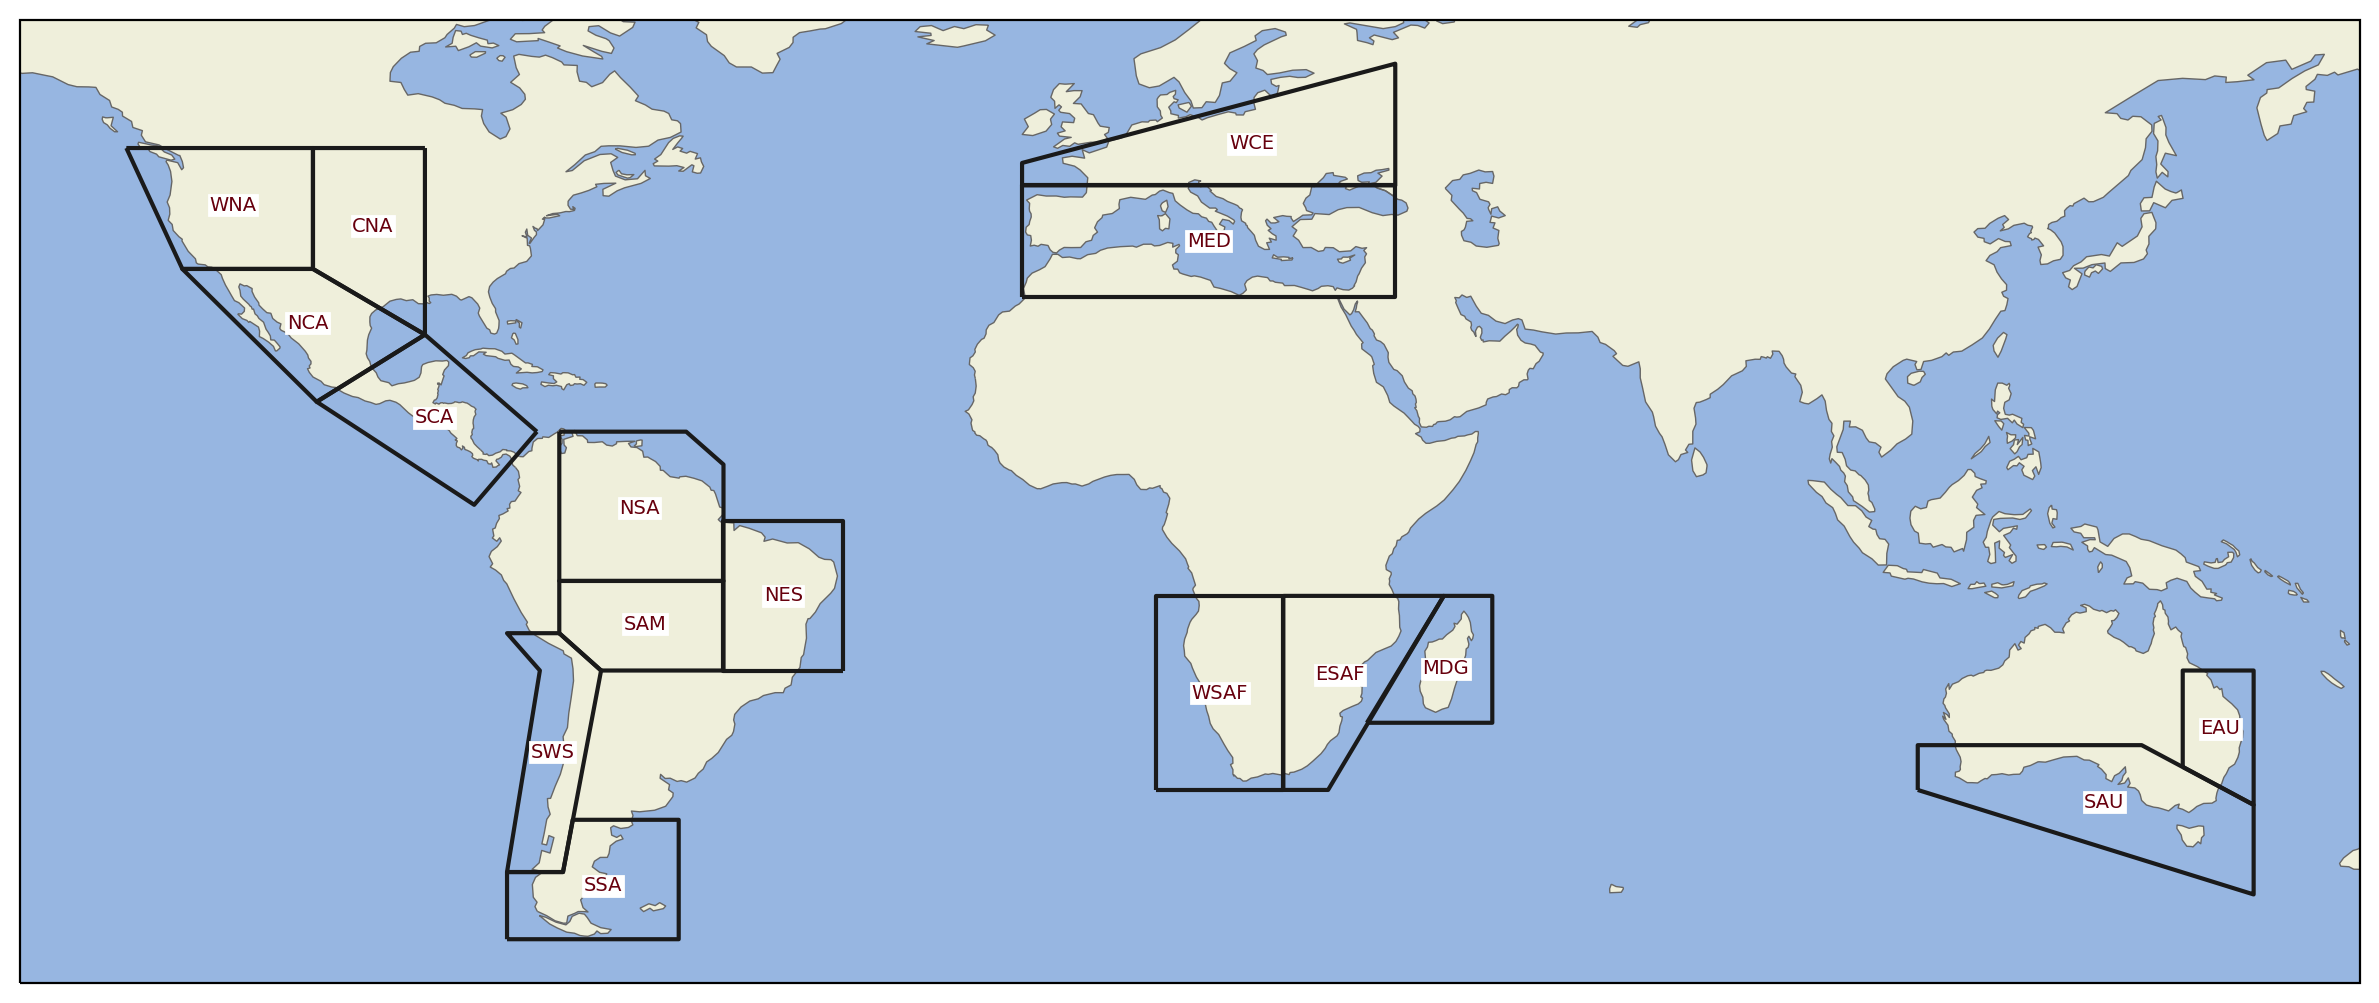

In [93]:
text_kws = dict(color = "#67000d", fontsize = 7, bbox = dict(pad = 0.2, color = "w"))

# for all regions
#regionmask.defined_regions.ar6.all.plot(text_kws = text_kws, add_ocean = True, add_land=True, label='abbrev');

# for drying regions
regionmask.defined_regions.ar6.all[['MED', 'WCE', 'WNA', 'CNA', 
                                    'NCA', 'SCA', 'NSA', 'NES', 
                                    'SAM', 'SWS', 'SSA', 'WSAF', 
                                    'ESAF', 'MDG', 'SAU', 'EAU']].plot(text_kws = text_kws, 
                                                                       add_ocean = True, 
                                                                       add_land = True, 
                                                                       label = 'abbrev');


plt.tight_layout()

In [94]:
def region_select(ds, region_codes):
    """ 
    region codes are defined by the regionmask package. more information is available in their documentation:
    https://regionmask.readthedocs.io/en/stable/defined_scientific.html
    
    region_codes: [list, of, region, codes]
    """ 
    ar6_region = regionmask.defined_regions.ar6.all
    mask = regionmask.defined_regions.ar6.all.mask(ds)
    ds_select = ds.where(xr.concat([mask == ar6_region.map_keys(region) for region in region_codes], dim='comp').max('comp'), drop = True)
    
    return ds_select  

In [95]:
dict_of_MED = {model : {} for model in models}
dict_of_WNA = {model : {} for model in models}

for model in tqdm(models):
    print('starting ' + model)
    #dict_of_MED[model] = region_select(ddict_concat[model], ['MED']).load()
    #dict_of_WNA[model] = region_select(ddict_concat[model], ['WNA']).load()
    dict_of_MED[model] = region_select(ds_depths[model], ['MED'])
    dict_of_WNA[model] = region_select(ds_depths[model], ['WNA'])

  0%|          | 0/1 [00:00<?, ?it/s]

starting TaiESM1


In [99]:
dict_of_MED['TaiESM1']

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 3012, lat: 16, lon: 39, depth: 3)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float32 30.63 31.57 32.51 33.46 ... 41.94 42.88 43.82 44.76
  * lon        (lon) float32 -8.75 -7.5 -6.25 -5.0 ... 35.0 36.25 37.5 38.75
  * member_id  (member_id) <U8 'r1i1p1f1'
  * depth      (depth) <U5 '30cm' '100cm' '200cm'
Data variables:
    mrsos      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 453, 16, 39), meta=np.ndarray>
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 396, 16, 39), meta=np.ndarray>
    mrsol      (depth, member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1, 31, 16, 39), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

In [106]:
#dict_of_MED['TaiESM1'].isel(time = 1).mrsos.plot()

#### Making sure the region select works

I'm a bit worried about the 0 values in some of the models, so flagging that it might be an issue going forward

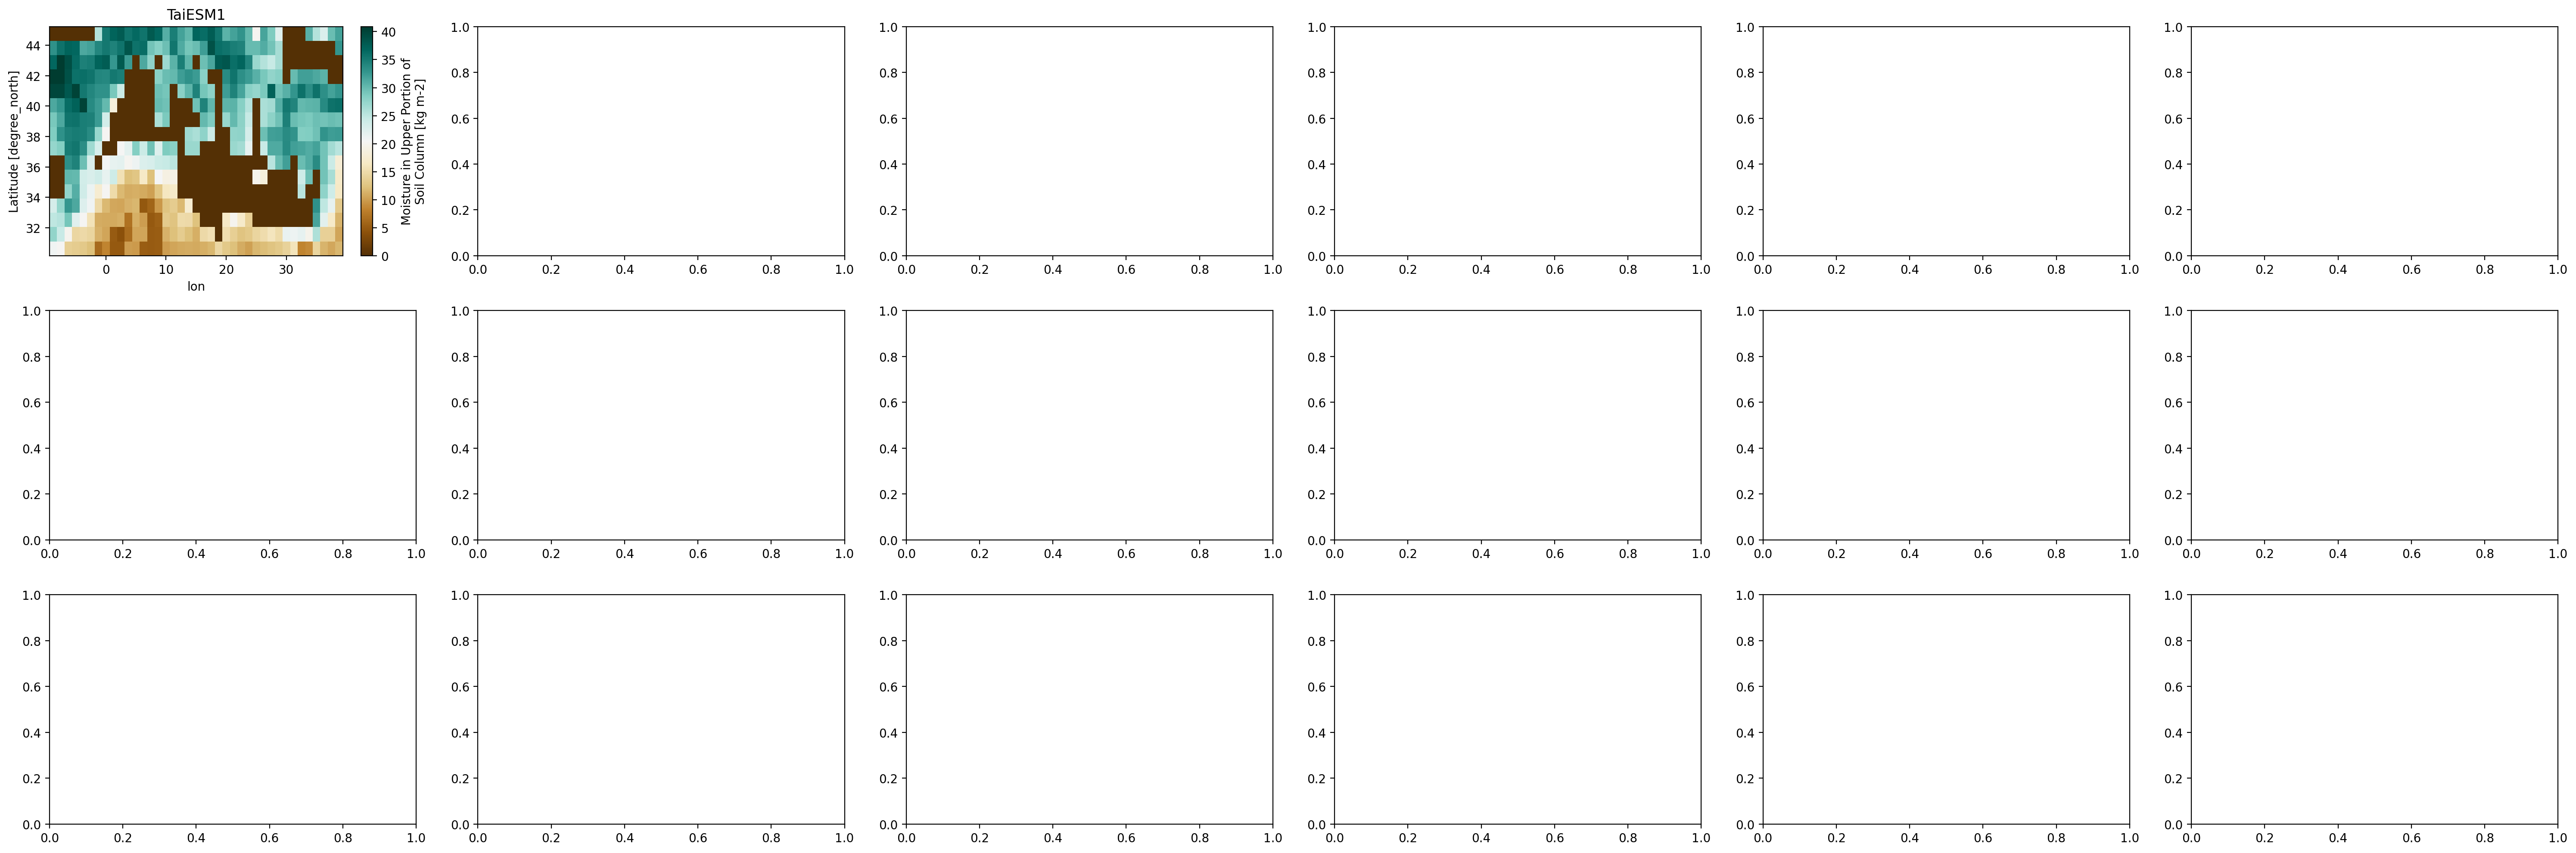

In [108]:
nrows = 3
ncols = 6

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [30, 10])

for ax, model in zip(axarr.flat, dict_of_MED.keys()):
    dict_of_MED[model].mrsos.isel(time = 1)[0].plot(cmap = 'BrBG', ax = ax)
    #ax.coastlines(zorder = 3)
    ax.set_title(model)
    
plt.tight_layout()

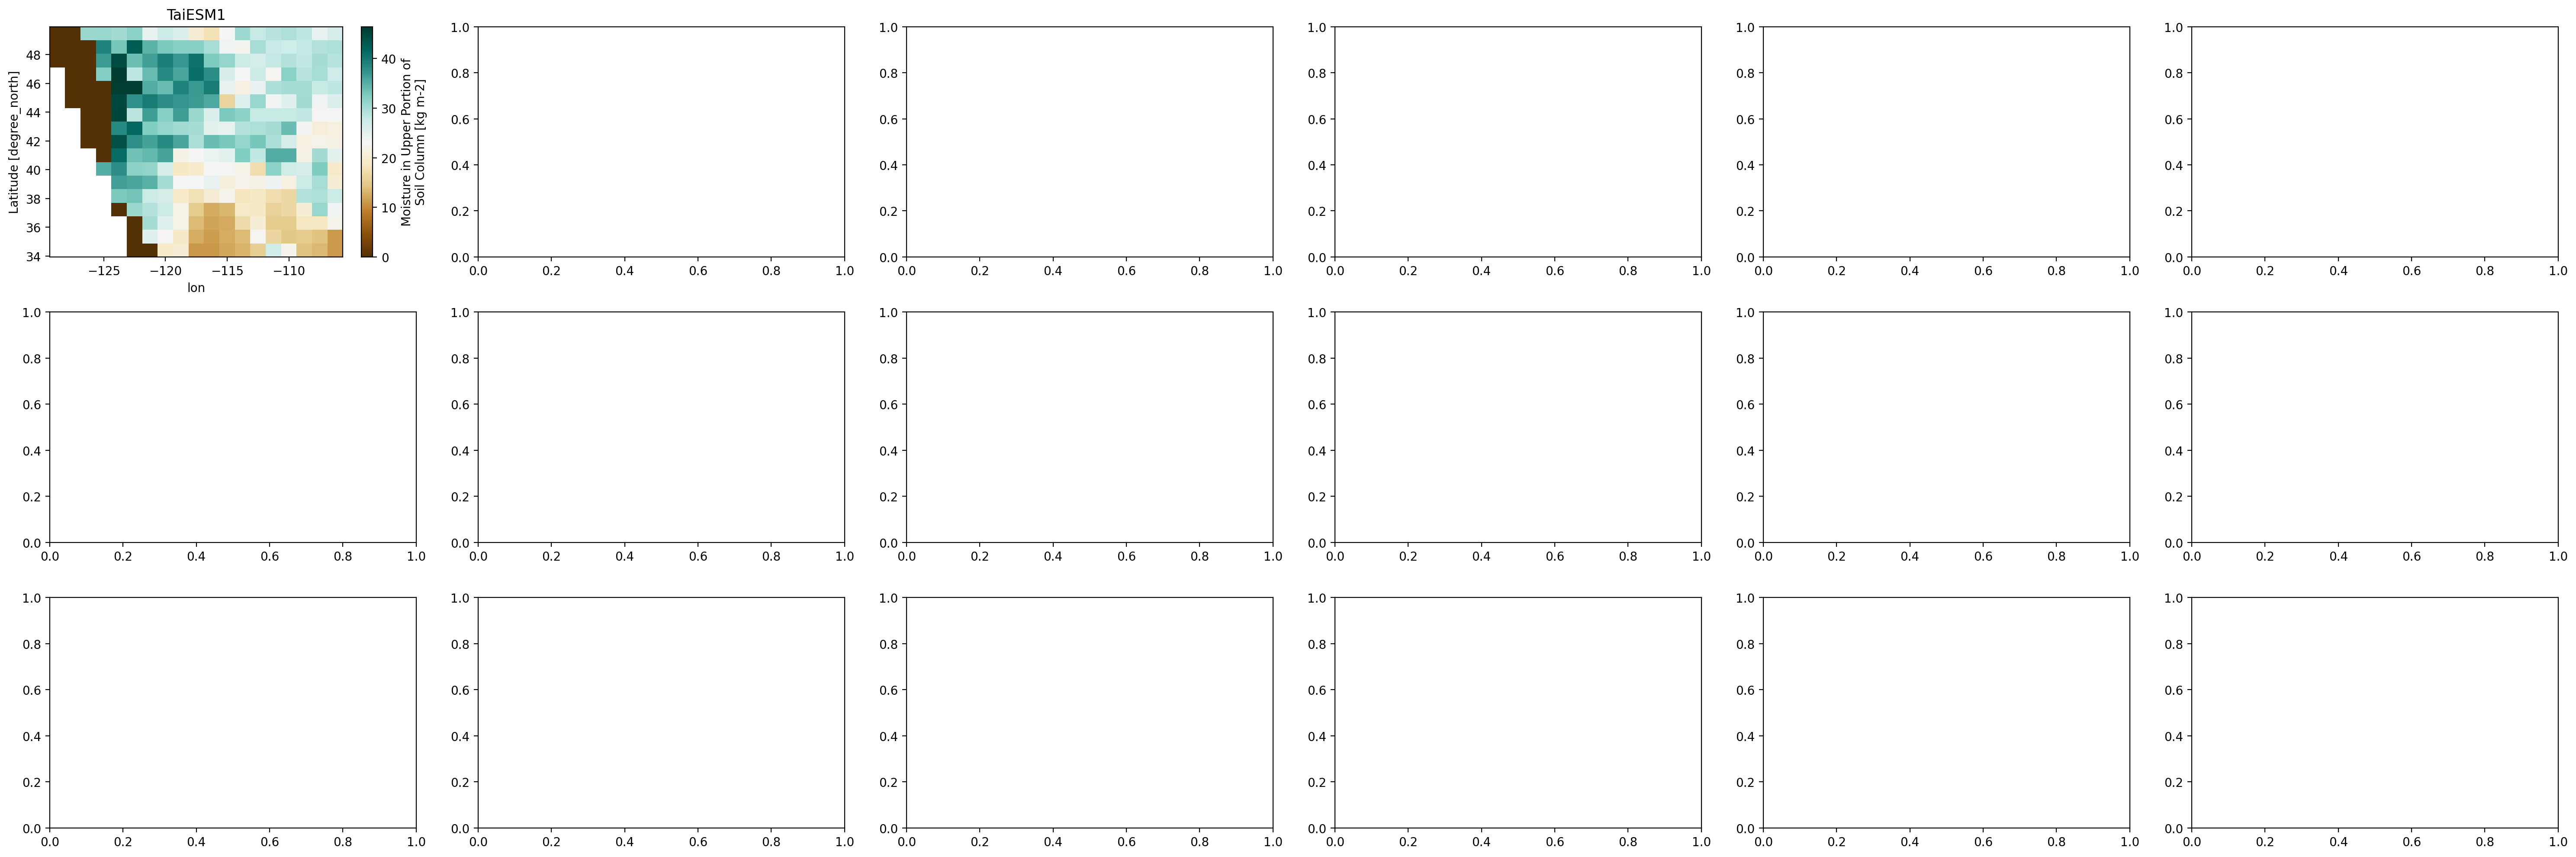

In [109]:
nrows = 3
ncols = 6

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [30, 10])

for ax, model in zip(axarr.flat, dict_of_MED.keys()):
    dict_of_WNA[model].mrsos.isel(time = 1)[0].plot(cmap = 'BrBG', ax = ax)
    #ax.coastlines(zorder = 3)
    ax.set_title(model)
    
plt.tight_layout()

In [110]:
#dict_of_MED = {model : {} for model in models}
#dict_of_WNA = {model : {} for model in models}

for model in tqdm(models):
    print('starting ' + model)
    #dict_of_MED[model] = region_select(ddict_concat[model], ['MED']).load()
    #dict_of_WNA[model] = region_select(ddict_concat[model], ['WNA']).load()
    dict_of_MED[model] = dict_of_MED[model].load()
    dict_of_WNA[model] = dict_of_WNA[model].load()

  0%|          | 0/1 [00:00<?, ?it/s]

starting TaiESM1


## Calculate Land Fraction

## Save processed region data

In [111]:
region = ['MED']
print_string = "-"
project_prefix = '~/precip-events/exported_data'
fn_prefix = '/regions/' + print_string.join(region) + '/'

for model in tqdm(dict_of_MED):
    print('starting ' + str(model))
    #try:
    dict_of_MED[model].to_netcdf(project_prefix + fn_prefix + model + '_depth_interpolated_' + print_string.join(variables) + '.nc')
    #except:
    #    print(str(model) + ' did not save')

  0%|          | 0/1 [00:00<?, ?it/s]

starting TaiESM1


In [112]:
region = ['WNA']

print_string = "-"
project_prefix = '~/precip-events/exported_data'
fn_prefix = '/regions/' + print_string.join(region) + '/' 

for model in tqdm(dict_of_WNA):
    print('starting ' + str(model))
    try:
        dict_of_WNA[model].to_netcdf(project_prefix + fn_prefix + model + '_depth_interpolated_' + print_string.join(variables) + '.nc')
    except:
        print(str(model) + ' did not save')

  0%|          | 0/1 [00:00<?, ?it/s]

starting TaiESM1


In [114]:
dict_of_WNA['TaiESM1']

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 3012, lat: 17, lon: 19, depth: 3)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float32 34.4 35.34 36.28 37.22 ... 46.65 47.59 48.53 49.48
  * lon        (lon) float32 -128.8 -127.5 -126.2 ... -108.8 -107.5 -106.2
  * member_id  (member_id) <U8 'r1i1p1f1'
  * depth      (depth) <U5 '30cm' '100cm' '200cm'
Data variables:
    mrsos      (member_id, time, lat, lon) float32 nan nan nan ... nan nan nan
    pr         (member_id, time, lat, lon) float32 nan nan ... 1.786e-05
    mrsol      (depth, member_id, time, lat, lon) float32 nan nan ... 0.0 0.0
Attributes:
    Conventions:  IRIDL